In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import shrimpy
import psycopg2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#implement linear regression
from sklearn.linear_model import LinearRegression

#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [3]:
class DatabaseClient:
    """
    Functionality for inserting and reading from the database
    """

    def __init__(self):
        # Connect to db
        self.con = psycopg2.connect(
            host='localhost',
            database='postgres',
            user='postgres',
            password='postgres'
        )
        self.article_table = pd.DataFrame()

    def read_db(self):
        cur = self.con.cursor()

        cur.execute("SELECT timestamp, comp_sentiment, sma, ema FROM sent_values WHERE timestamp > '2021-01-26 15:00:00'::timestamp;")

        rows = cur.fetchall()

        self.article_table = pd.DataFrame(data=rows, columns=['timestamp','compound','sma','ema'])


        return self.article_table

In [4]:
def get_latest_prices(trading_symbol):
    public_key = '12326758a39a720e15d064cab3c1f0a9332d107de453bd41926bb3acd565059e'
    secret_key = '6991cf4c9b518293429db0df6085d1731074bed8abccd7f0279a52fac5b0c1a8a2f6d28e11a50fbb1c6575d1407e637f9ad7c73fbddfa87c5d418fd58971f829'
    
    client = shrimpy.ShrimpyApiClient(public_key, secret_key)
        
    # get the candles for historical values
    candles = client.get_candles(
        'binance',  # exchange
        trading_symbol,      # base_trading_symbol
        'USDT',      # quote_trading_symbol
        '1h'       # interval
    )
        
    # Set the dataframe between these two dates
    tomorrows_date = (datetime.today() - timedelta(hours=1)).strftime("%Y-%m-%d %H:00")
    tomorrows_date = (datetime.today()).strftime("%Y-%m-%d %H:00")
    starting_date = '2021-01-25 02:00:00'

    # Put pulled cryptocurrency values into a dataframe and set dates
    prices_df = pd.DataFrame(candles)
    prices_df['time'] = pd.to_datetime(prices_df['time'], infer_datetime_format=True).dt.tz_localize(None)

    latest_prices = prices_df[(prices_df['time'] > starting_date) & (prices_df['time'] <tomorrows_date)]
    latest_prices['close'] = latest_prices['close'].astype('float64')

    return latest_prices

In [11]:
database_client = DatabaseClient()
df = database_client.read_db()
df.index = df.timestamp
df = df.iloc[:-1]

data = get_latest_prices('BTC')
data.index = data.time
data = data.iloc[:-4]

dataset_train = data.join(df, lsuffix=data.index, rsuffix=df.index)

comp_df = dataset_train[['close', 'compound']]
comp_df = comp_df.astype('float')
#comp_df.to_csv('/bitcoin_price.csv')

dataset_train = dataset_train.drop(columns=['open', 'high', 'low', 'volume', 'quoteVolume', 'btcVolume', 'usdVolume','time','timestamp','compound'])
dataset_train = dataset_train.dropna()
dataset_train = dataset_train.astype('float')

<ipython-input-4-b1d27c6bb073>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_prices['close'] = latest_prices['close'].astype('float64')


# Data Preprocessing

In [453]:
#split into train and validation
train = dataset_train[:750]
valid = dataset_train[750:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [454]:
#make predictions and find the rmse
preds = model.predict(x_valid)
lr_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
lr_rms

8342.814975908545

<ipython-input-455-5698932f743b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-455-5698932f743b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


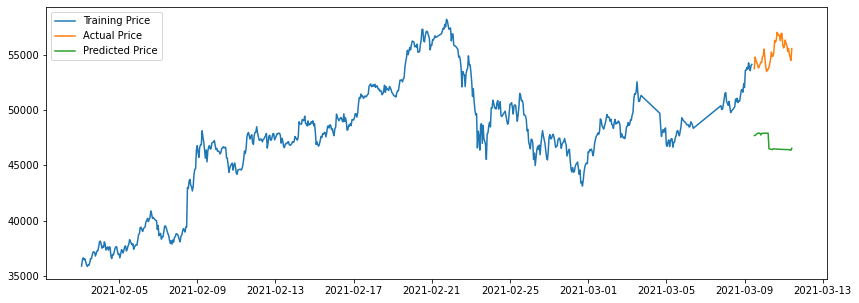

In [455]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = dataset_train[750:].index
train.index = dataset_train[:750].index

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# K Nearest Neighbour

In [549]:
scaler = MinMaxScaler(feature_range=(0, 1))

#split into train and validation
train = dataset_train[:750]
valid = dataset_train[750:]

x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

In [550]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [551]:
#rmse
knn_rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
knn_rms

6945.997494207722

<ipython-input-553-1945932430b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
<ipython-input-553-1945932430b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


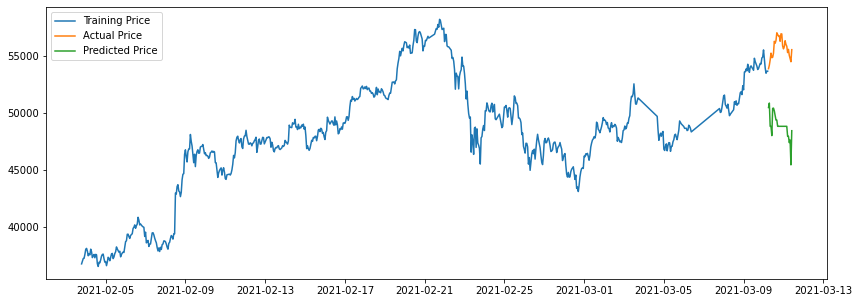

In [553]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Standard LSTM

In [460]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/10
690/690 - 11s - loss: 0.0057
Epoch 2/10
690/690 - 8s - loss: 0.0021
Epoch 3/10
690/690 - 9s - loss: 0.0015
Epoch 4/10
690/690 - 8s - loss: 0.0015
Epoch 5/10
690/690 - 8s - loss: 0.0012
Epoch 6/10
690/690 - 7s - loss: 9.9302e-04
Epoch 7/10
690/690 - 8s - loss: 9.7987e-04
Epoch 8/10
690/690 - 7s - loss: 0.0011
Epoch 9/10
690/690 - 7s - loss: 9.0922e-04
Epoch 10/10
690/690 - 7s - loss: 8.9241e-04


In [461]:
lstm_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_rms

551.0570863810728

<ipython-input-462-025710875cb5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


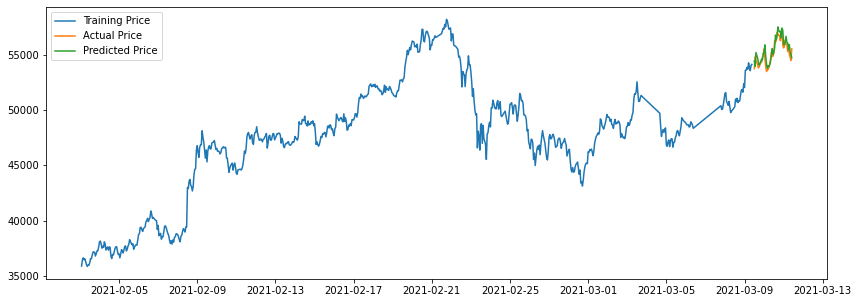

In [462]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Multivariate LSTM

In [585]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Compound'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Compound'][i] = comp_df['compound'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values.astype('float')

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))



# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/10
690/690 - 12s - loss: 0.0067 - accuracy: 0.0014
Epoch 2/10
690/690 - 9s - loss: 0.0024 - accuracy: 0.0014
Epoch 3/10
690/690 - 8s - loss: 0.0018 - accuracy: 0.0014
Epoch 4/10
690/690 - 8s - loss: 0.0015 - accuracy: 0.0014
Epoch 5/10
690/690 - 9s - loss: 0.0013 - accuracy: 0.0014
Epoch 6/10
690/690 - 9s - loss: 0.0010 - accuracy: 0.0014
Epoch 7/10
690/690 - 10s - loss: 9.9801e-04 - accuracy: 0.0014
Epoch 8/10
690/690 - 9s - loss: 9.2213e-04 - accuracy: 0.0014
Epoch 9/10
690/690 - 8s - loss: 9.5754e-04 - accuracy: 0.0014
Epoch 10/10
690/690 - 8s - loss: 9.1412e-04 - accuracy: 0.0014
[0.006694961804896593, 0.0023799967020750046, 0.0018017471302300692, 0.0014977868413552642, 0.0012710965238511562, 0.001029673032462597, 0.0009980095783248544, 0.0009221297223120928, 0.0009575352887623012, 0.0009141219779849052]
[0.0014492754125967622, 0.0014492754125967622, 0.0014492754125967622, 0.0014492754125967622, 0.0014492754125967622, 0.0014492754125967622, 0.0014492754125967622, 0.00144927

In [586]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [587]:
valid = np.nan_to_num(valid)
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

279.1227685210413

<ipython-input-588-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


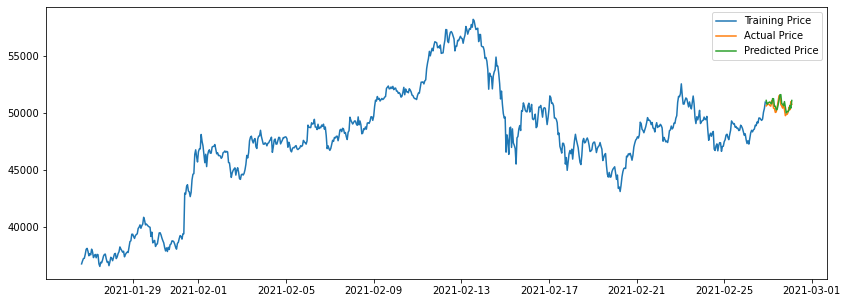

In [588]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

In [10]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Compound'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Compound'][i] = comp_df['compound'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values.astype('float')

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_data = scaler.fit_transform(train)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(train_scaled_data[i-60:i,0])
    y_train.append(train_scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
valid_scaled_data = scaler.fit_transform(valid)

x_valid, y_valid = [], []
for i in range(1,len(valid)):
    x_valid.append(valid_scaled_data[i-1:i,0])
    y_valid.append(valid_scaled_data[i,0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

x_valid = np.reshape(x_valid, (x_valid.shape[0],x_valid.shape[1],1))

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(90, x_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')


rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(x_train, y_train, shuffle=True, epochs=100, callbacks=[rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/100


ValueError: in user code:

    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\RMacW\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_3: expected shape=(None, None, 59), found shape=(None, 60, 1)


Epoch 1/800
690/690 - 9s - loss: 0.0038 - accuracy: 0.0014 - val_loss: 0.0813 - val_accuracy: 0.0357
Epoch 2/800
690/690 - 8s - loss: 0.0057 - accuracy: 0.0014 - val_loss: 0.0585 - val_accuracy: 0.0357
Epoch 3/800
690/690 - 8s - loss: 0.0064 - accuracy: 0.0014 - val_loss: 0.0503 - val_accuracy: 0.0714
Epoch 4/800
690/690 - 8s - loss: 0.0060 - accuracy: 0.0014 - val_loss: 0.0468 - val_accuracy: 0.0714
Epoch 5/800
690/690 - 8s - loss: 0.0051 - accuracy: 0.0014 - val_loss: 0.0434 - val_accuracy: 0.0714
Epoch 6/800
690/690 - 8s - loss: 0.0038 - accuracy: 0.0014 - val_loss: 0.0416 - val_accuracy: 0.0714
Epoch 7/800
690/690 - 8s - loss: 0.0026 - accuracy: 0.0014 - val_loss: 0.0408 - val_accuracy: 0.0714
Epoch 8/800
690/690 - 8s - loss: 0.0018 - accuracy: 0.0014 - val_loss: 0.0424 - val_accuracy: 0.0714
Epoch 9/800
690/690 - 8s - loss: 0.0014 - accuracy: 0.0014 - val_loss: 0.0453 - val_accuracy: 0.0714
Epoch 10/800
690/690 - 8s - loss: 0.0012 - accuracy: 0.0014 - val_loss: 0.0454 - val_accura

Epoch 77/800
690/690 - 7s - loss: 8.3326e-04 - accuracy: 0.0014 - val_loss: 0.0429 - val_accuracy: 0.0714
Epoch 78/800
690/690 - 7s - loss: 8.8989e-04 - accuracy: 0.0014 - val_loss: 0.0538 - val_accuracy: 0.0714
Epoch 79/800
690/690 - 7s - loss: 8.1806e-04 - accuracy: 0.0014 - val_loss: 0.0436 - val_accuracy: 0.0714
Epoch 80/800
690/690 - 7s - loss: 7.9391e-04 - accuracy: 0.0014 - val_loss: 0.0554 - val_accuracy: 0.0714
Epoch 81/800
690/690 - 7s - loss: 7.8594e-04 - accuracy: 0.0014 - val_loss: 0.0439 - val_accuracy: 0.0714
Epoch 82/800
690/690 - 7s - loss: 7.6914e-04 - accuracy: 0.0014 - val_loss: 0.0446 - val_accuracy: 0.0714
Epoch 83/800
690/690 - 7s - loss: 7.6936e-04 - accuracy: 0.0014 - val_loss: 0.0474 - val_accuracy: 0.0714
Epoch 84/800
690/690 - 7s - loss: 0.0013 - accuracy: 0.0014 - val_loss: 0.0368 - val_accuracy: 0.0714
Epoch 85/800
690/690 - 7s - loss: 0.0016 - accuracy: 0.0014 - val_loss: 0.0401 - val_accuracy: 0.0714
Epoch 86/800
690/690 - 7s - loss: 0.0011 - accuracy: 0

Epoch 155/800
690/690 - 7s - loss: 8.6316e-04 - accuracy: 0.0014 - val_loss: 0.0506 - val_accuracy: 0.0714
Epoch 156/800
690/690 - 7s - loss: 8.1523e-04 - accuracy: 0.0014 - val_loss: 0.0498 - val_accuracy: 0.0714
Epoch 157/800
690/690 - 7s - loss: 7.0924e-04 - accuracy: 0.0014 - val_loss: 0.0600 - val_accuracy: 0.0714
Epoch 158/800
690/690 - 7s - loss: 8.5585e-04 - accuracy: 0.0014 - val_loss: 0.0603 - val_accuracy: 0.0714
Epoch 159/800
690/690 - 7s - loss: 0.0014 - accuracy: 0.0014 - val_loss: 0.0437 - val_accuracy: 0.0714
Epoch 160/800
690/690 - 7s - loss: 7.9049e-04 - accuracy: 0.0014 - val_loss: 0.0506 - val_accuracy: 0.0714
Epoch 161/800
690/690 - 7s - loss: 7.9040e-04 - accuracy: 0.0014 - val_loss: 0.0661 - val_accuracy: 0.0714
Epoch 162/800
690/690 - 7s - loss: 7.6457e-04 - accuracy: 0.0014 - val_loss: 0.0711 - val_accuracy: 0.0714
Epoch 163/800
690/690 - 7s - loss: 9.9574e-04 - accuracy: 0.0014 - val_loss: 0.0627 - val_accuracy: 0.0714
Epoch 164/800
690/690 - 7s - loss: 8.1621

Epoch 232/800
690/690 - 8s - loss: 9.0026e-04 - accuracy: 0.0014 - val_loss: 0.0583 - val_accuracy: 0.0714
Epoch 233/800
690/690 - 8s - loss: 8.6650e-04 - accuracy: 0.0014 - val_loss: 0.0670 - val_accuracy: 0.0714
Epoch 234/800
690/690 - 8s - loss: 7.6077e-04 - accuracy: 0.0014 - val_loss: 0.0606 - val_accuracy: 0.0714
Epoch 235/800
690/690 - 8s - loss: 8.0429e-04 - accuracy: 0.0014 - val_loss: 0.0503 - val_accuracy: 0.0714
Epoch 236/800
690/690 - 8s - loss: 7.2111e-04 - accuracy: 0.0014 - val_loss: 0.0514 - val_accuracy: 0.0714
Epoch 237/800
690/690 - 8s - loss: 7.0170e-04 - accuracy: 0.0014 - val_loss: 0.0533 - val_accuracy: 0.0714
Epoch 238/800
690/690 - 7s - loss: 7.0408e-04 - accuracy: 0.0014 - val_loss: 0.0571 - val_accuracy: 0.0714
Epoch 239/800
690/690 - 8s - loss: 7.6468e-04 - accuracy: 0.0014 - val_loss: 0.0567 - val_accuracy: 0.0714
Epoch 240/800
690/690 - 8s - loss: 7.7815e-04 - accuracy: 0.0014 - val_loss: 0.0609 - val_accuracy: 0.0714
Epoch 241/800
690/690 - 8s - loss: 6.

Epoch 309/800
690/690 - 8s - loss: 7.4114e-04 - accuracy: 0.0014 - val_loss: 0.0703 - val_accuracy: 0.0714
Epoch 310/800
690/690 - 8s - loss: 6.8251e-04 - accuracy: 0.0014 - val_loss: 0.0650 - val_accuracy: 0.0714
Epoch 311/800
690/690 - 8s - loss: 7.2019e-04 - accuracy: 0.0014 - val_loss: 0.0689 - val_accuracy: 0.0714
Epoch 312/800
690/690 - 8s - loss: 7.1887e-04 - accuracy: 0.0014 - val_loss: 0.0734 - val_accuracy: 0.0714
Epoch 313/800
690/690 - 8s - loss: 6.7071e-04 - accuracy: 0.0014 - val_loss: 0.0749 - val_accuracy: 0.0714
Epoch 314/800
690/690 - 8s - loss: 6.2087e-04 - accuracy: 0.0014 - val_loss: 0.0752 - val_accuracy: 0.0714
Epoch 315/800
690/690 - 8s - loss: 6.4319e-04 - accuracy: 0.0014 - val_loss: 0.0719 - val_accuracy: 0.0714
Epoch 316/800
690/690 - 8s - loss: 6.5971e-04 - accuracy: 0.0014 - val_loss: 0.0713 - val_accuracy: 0.0714
Epoch 317/800
690/690 - 8s - loss: 6.4287e-04 - accuracy: 0.0014 - val_loss: 0.0720 - val_accuracy: 0.0714
Epoch 318/800
690/690 - 8s - loss: 6.

Epoch 386/800
690/690 - 8s - loss: 6.9843e-04 - accuracy: 0.0014 - val_loss: 0.0934 - val_accuracy: 0.0714
Epoch 387/800
690/690 - 8s - loss: 0.0013 - accuracy: 0.0014 - val_loss: 0.1076 - val_accuracy: 0.0714
Epoch 388/800
690/690 - 8s - loss: 8.8551e-04 - accuracy: 0.0014 - val_loss: 0.1046 - val_accuracy: 0.0714
Epoch 389/800
690/690 - 7s - loss: 6.6665e-04 - accuracy: 0.0014 - val_loss: 0.0943 - val_accuracy: 0.0714
Epoch 390/800
690/690 - 8s - loss: 7.4258e-04 - accuracy: 0.0014 - val_loss: 0.0855 - val_accuracy: 0.0714
Epoch 391/800
690/690 - 8s - loss: 8.3131e-04 - accuracy: 0.0014 - val_loss: 0.0956 - val_accuracy: 0.0714
Epoch 392/800
690/690 - 8s - loss: 7.9956e-04 - accuracy: 0.0014 - val_loss: 0.0874 - val_accuracy: 0.0714
Epoch 393/800
690/690 - 8s - loss: 9.4788e-04 - accuracy: 0.0014 - val_loss: 0.0792 - val_accuracy: 0.0714
Epoch 394/800
690/690 - 8s - loss: 7.1024e-04 - accuracy: 0.0014 - val_loss: 0.0778 - val_accuracy: 0.0714
Epoch 395/800
690/690 - 8s - loss: 8.4316

Epoch 463/800
690/690 - 8s - loss: 5.8842e-04 - accuracy: 0.0014 - val_loss: 0.0727 - val_accuracy: 0.0714
Epoch 464/800
690/690 - 8s - loss: 6.0357e-04 - accuracy: 0.0014 - val_loss: 0.0723 - val_accuracy: 0.0714
Epoch 465/800
690/690 - 8s - loss: 5.8394e-04 - accuracy: 0.0014 - val_loss: 0.0721 - val_accuracy: 0.0714
Epoch 466/800
690/690 - 8s - loss: 5.7185e-04 - accuracy: 0.0014 - val_loss: 0.0707 - val_accuracy: 0.0714
Epoch 467/800
690/690 - 8s - loss: 5.8464e-04 - accuracy: 0.0014 - val_loss: 0.0685 - val_accuracy: 0.0714
Epoch 468/800
690/690 - 8s - loss: 5.5591e-04 - accuracy: 0.0014 - val_loss: 0.0650 - val_accuracy: 0.0714
Epoch 469/800
690/690 - 8s - loss: 6.2474e-04 - accuracy: 0.0014 - val_loss: 0.0696 - val_accuracy: 0.0714
Epoch 470/800
690/690 - 8s - loss: 6.1604e-04 - accuracy: 0.0014 - val_loss: 0.0647 - val_accuracy: 0.0714
Epoch 471/800
690/690 - 7s - loss: 8.1774e-04 - accuracy: 0.0014 - val_loss: 0.0637 - val_accuracy: 0.0714
Epoch 472/800
690/690 - 8s - loss: 8.

Epoch 540/800
690/690 - 24s - loss: 6.6288e-04 - accuracy: 0.0014 - val_loss: 0.0782 - val_accuracy: 0.0714
Epoch 541/800
690/690 - 19s - loss: 6.6849e-04 - accuracy: 0.0014 - val_loss: 0.0790 - val_accuracy: 0.0714
Epoch 542/800
690/690 - 24s - loss: 6.5925e-04 - accuracy: 0.0014 - val_loss: 0.0746 - val_accuracy: 0.0714
Epoch 543/800
690/690 - 20s - loss: 6.7854e-04 - accuracy: 0.0014 - val_loss: 0.0769 - val_accuracy: 0.0714
Epoch 544/800
690/690 - 22s - loss: 6.3102e-04 - accuracy: 0.0014 - val_loss: 0.0782 - val_accuracy: 0.0714
Epoch 545/800
690/690 - 22s - loss: 7.0561e-04 - accuracy: 0.0014 - val_loss: 0.0670 - val_accuracy: 0.0714
Epoch 546/800
690/690 - 21s - loss: 6.5992e-04 - accuracy: 0.0014 - val_loss: 0.0687 - val_accuracy: 0.0714
Epoch 547/800
690/690 - 22s - loss: 6.3836e-04 - accuracy: 0.0014 - val_loss: 0.0675 - val_accuracy: 0.0714
Epoch 548/800
690/690 - 22s - loss: 0.0017 - accuracy: 0.0014 - val_loss: 0.0684 - val_accuracy: 0.0714
Epoch 549/800
690/690 - 23s - lo

Epoch 616/800
690/690 - 23s - loss: 0.0024 - accuracy: 0.0014 - val_loss: 0.0640 - val_accuracy: 0.0714
Epoch 617/800
690/690 - 15s - loss: 0.0018 - accuracy: 0.0014 - val_loss: 0.0601 - val_accuracy: 0.0714
Epoch 618/800
690/690 - 11s - loss: 0.0013 - accuracy: 0.0014 - val_loss: 0.0595 - val_accuracy: 0.0714
Epoch 619/800
690/690 - 11s - loss: 0.0011 - accuracy: 0.0014 - val_loss: 0.0594 - val_accuracy: 0.0714
Epoch 620/800
690/690 - 14s - loss: 9.3835e-04 - accuracy: 0.0014 - val_loss: 0.0630 - val_accuracy: 0.0714
Epoch 621/800
690/690 - 20s - loss: 9.7773e-04 - accuracy: 0.0014 - val_loss: 0.0599 - val_accuracy: 0.0714
Epoch 622/800
690/690 - 21s - loss: 8.6794e-04 - accuracy: 0.0014 - val_loss: 0.0623 - val_accuracy: 0.0714
Epoch 623/800
690/690 - 22s - loss: 9.6921e-04 - accuracy: 0.0014 - val_loss: 0.0605 - val_accuracy: 0.0714
Epoch 624/800
690/690 - 21s - loss: 9.9614e-04 - accuracy: 0.0014 - val_loss: 0.0628 - val_accuracy: 0.0714
Epoch 625/800
690/690 - 22s - loss: 9.5731e-

690/690 - 23s - loss: 4.8938e-04 - accuracy: 0.0014 - val_loss: 0.0739 - val_accuracy: 0.0714
Epoch 693/800
690/690 - 22s - loss: 4.8692e-04 - accuracy: 0.0014 - val_loss: 0.0725 - val_accuracy: 0.0714
Epoch 694/800
690/690 - 22s - loss: 4.8466e-04 - accuracy: 0.0014 - val_loss: 0.0729 - val_accuracy: 0.0714
Epoch 695/800
690/690 - 22s - loss: 4.8249e-04 - accuracy: 0.0014 - val_loss: 0.0711 - val_accuracy: 0.0714
Epoch 696/800
690/690 - 22s - loss: 5.1122e-04 - accuracy: 0.0014 - val_loss: 0.0747 - val_accuracy: 0.0714
Epoch 697/800
690/690 - 22s - loss: 5.8624e-04 - accuracy: 0.0014 - val_loss: 0.0789 - val_accuracy: 0.0714
Epoch 698/800
690/690 - 22s - loss: 5.4133e-04 - accuracy: 0.0014 - val_loss: 0.0783 - val_accuracy: 0.0714
Epoch 699/800
690/690 - 22s - loss: 5.5780e-04 - accuracy: 0.0014 - val_loss: 0.0770 - val_accuracy: 0.0714
Epoch 700/800
690/690 - 21s - loss: 5.0029e-04 - accuracy: 0.0014 - val_loss: 0.0777 - val_accuracy: 0.0714
Epoch 701/800
690/690 - 21s - loss: 4.9165

690/690 - 10s - loss: 4.2686e-04 - accuracy: 0.0014 - val_loss: 0.0740 - val_accuracy: 0.0714
Epoch 769/800
690/690 - 10s - loss: 3.9135e-04 - accuracy: 0.0014 - val_loss: 0.0768 - val_accuracy: 0.0357
Epoch 770/800
690/690 - 10s - loss: 5.8107e-04 - accuracy: 0.0014 - val_loss: 0.0781 - val_accuracy: 0.0714
Epoch 771/800
690/690 - 10s - loss: 6.3599e-04 - accuracy: 0.0014 - val_loss: 0.0787 - val_accuracy: 0.0714
Epoch 772/800
690/690 - 10s - loss: 5.3735e-04 - accuracy: 0.0014 - val_loss: 0.0811 - val_accuracy: 0.0714
Epoch 773/800
690/690 - 10s - loss: 4.5760e-04 - accuracy: 0.0014 - val_loss: 0.0781 - val_accuracy: 0.0714
Epoch 774/800
690/690 - 10s - loss: 6.0881e-04 - accuracy: 0.0014 - val_loss: 0.0787 - val_accuracy: 0.0714
Epoch 775/800
690/690 - 10s - loss: 6.3266e-04 - accuracy: 0.0014 - val_loss: 0.0793 - val_accuracy: 0.0714
Epoch 776/800
690/690 - 10s - loss: 7.7303e-04 - accuracy: 0.0014 - val_loss: 0.0799 - val_accuracy: 0.0357
Epoch 777/800
690/690 - 10s - loss: 7.5168

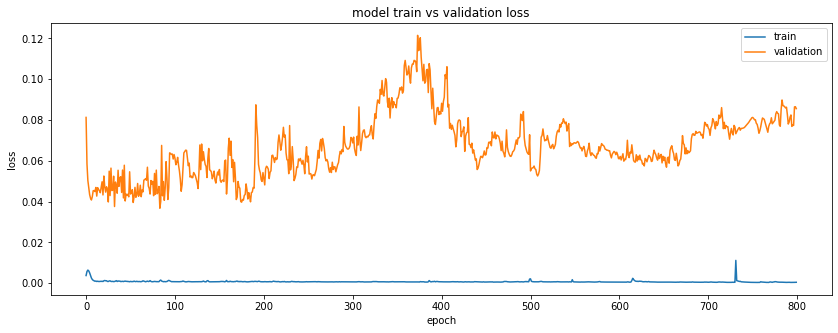

In [619]:
from matplotlib import pyplot

#history = model.fit(X, Y, epochs=100, validation_data=(valX, valY))
history = model.fit(x_train, y_train, epochs=800, batch_size=1, validation_data=(x_valid, y_valid), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Multivariate LSTM SMA

In [570]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'SMA'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['SMA'][i] = dataset_train['sma'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 11s - loss: 0.0072
Epoch 2/10
690/690 - 8s - loss: 0.0023
Epoch 3/10
690/690 - 8s - loss: 0.0018
Epoch 4/10
690/690 - 8s - loss: 0.0016
Epoch 5/10
690/690 - 8s - loss: 0.0013
Epoch 6/10
690/690 - 8s - loss: 0.0011
Epoch 7/10
690/690 - 8s - loss: 0.0012
Epoch 8/10
690/690 - 8s - loss: 0.0011
Epoch 9/10
690/690 - 8s - loss: 9.0491e-04
Epoch 10/10
690/690 - 8s - loss: 9.3008e-04


In [571]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [572]:
lstm_sma_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_sma_rms

678.6901054863671

<ipython-input-573-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


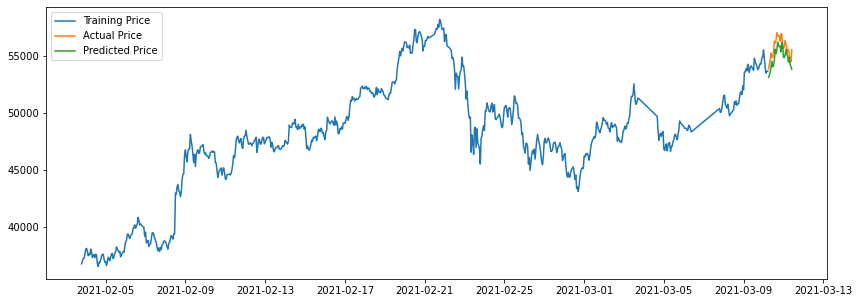

In [573]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# EMA MultiVariate LSTM

In [574]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'EMA'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['EMA'][i] = dataset_train['ema'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 11s - loss: 0.0059
Epoch 2/10
690/690 - 8s - loss: 0.0024
Epoch 3/10
690/690 - 8s - loss: 0.0016
Epoch 4/10
690/690 - 8s - loss: 0.0015
Epoch 5/10
690/690 - 8s - loss: 0.0013
Epoch 6/10
690/690 - 7s - loss: 0.0012
Epoch 7/10
690/690 - 7s - loss: 9.5505e-04
Epoch 8/10
690/690 - 7s - loss: 0.0010
Epoch 9/10
690/690 - 7s - loss: 9.7462e-04
Epoch 10/10
690/690 - 7s - loss: 0.0010


In [575]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [576]:
lstm_ema_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_ema_rms

710.2305690557791

<ipython-input-577-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


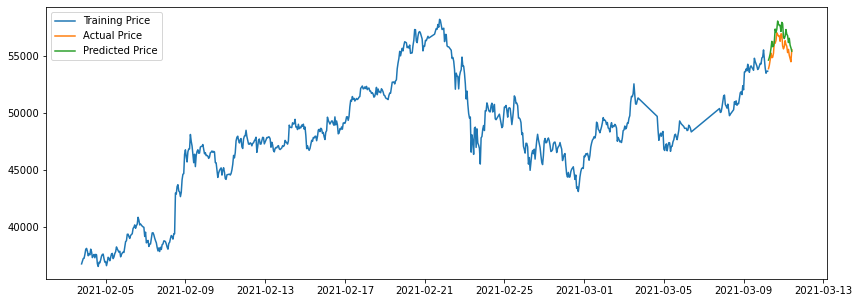

In [577]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin MultiVariate LSTM

In [578]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

comp_df['compound'] = comp_df['compound'].fillna(0)
comp_df['rank'] = comp_df['compound'].rank(method='first')

comp_df['bin'] = pd.qcut(comp_df['rank'], q=5, labels=bin_labels)

In [537]:
#creating dataframe
data = comp_df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(comp_df)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(comp_df)):
    new_data['Date'][i] = comp_df.index[i]
    new_data['Close'][i] = comp_df['close'][i]
    new_data['Bin'][i] = comp_df['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
690/690 - 10s - loss: 0.0046
Epoch 2/10
690/690 - 8s - loss: 0.0015
Epoch 3/10
690/690 - 7s - loss: 0.0012
Epoch 4/10
690/690 - 7s - loss: 0.0011
Epoch 5/10
690/690 - 7s - loss: 9.1107e-04
Epoch 6/10
690/690 - 7s - loss: 8.0726e-04
Epoch 7/10
690/690 - 7s - loss: 7.8448e-04
Epoch 8/10
690/690 - 7s - loss: 7.1568e-04
Epoch 9/10
690/690 - 7s - loss: 6.8414e-04
Epoch 10/10
690/690 - 7s - loss: 6.8845e-04


In [538]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [539]:
lstm_comp_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_comp_rms

762.7418659800528

<ipython-input-540-884ef8ca4d3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price[:,0]


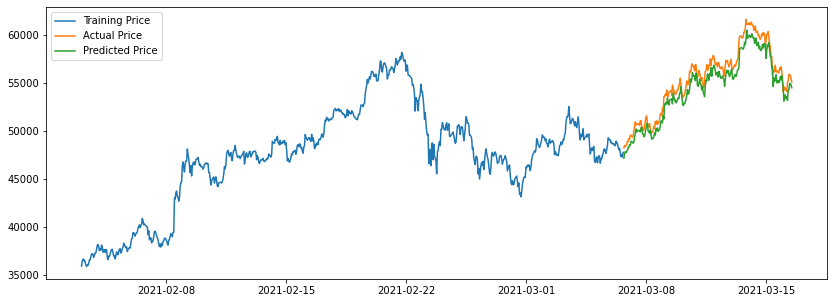

In [540]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin SMA MultiVariate LSTM

In [ ]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

dataset_train['bin'] = pd.qcut(dataset_train['sma'], q=5, labels=bin_labels)

In [ ]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['Bin'][i] = dataset_train['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [ ]:
lstm_sma_bin_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_sma_bin_rms

In [ ]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Bin EMA MultiVariate LSTM

In [ ]:
bin_labels = [-1, -0.01, 0, 0.01, 1]

dataset_train['bin'] = pd.qcut(dataset_train['ema'], q=5, labels=bin_labels)

In [ ]:
#creating dataframe
data = dataset_train.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(dataset_train)),columns=['Date', 'Close', 'Bin'])
for i in range(0,len(dataset_train)):
    new_data['Date'][i] = dataset_train.index[i]
    new_data['Close'][i] = dataset_train['close'][i]
    new_data['Bin'][i] = dataset_train['bin'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:750,:]
valid = dataset[750:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-inputs.shape[1],inputs.shape[1])
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
closing_price = model.predict(X_test)

# invert scaling for forecast
inv_yhat = np.concatenate((closing_price,X_test[:,-2]), axis=1)
closing_price = scaler.inverse_transform(inv_yhat)

In [ ]:
lstm_ema_bin_rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
lstm_ema_bin_rms

In [ ]:
#for plotting
train = new_data[:750]
valid = new_data[750:]
valid['Predictions'] = closing_price[:,0]
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

plt.legend(labels=['Training Price', 'Actual Price', 'Predicted Price'])

# Evaluation

In [ ]:
# Create a Dataframe with the results.
d = {'Classifiers': ['Linear Regression', 'KNN','Standard LSTM', 'LSTM with SMA', 'LSTM with Binned SMA', 'LSTM with EMA', 'LSTM with Binned EMA'], 
    'Root Mean Square': [lr_rms, knn_rms, lstm_rms, lstm_sma_rms, lstm_sma_bin_rms, lstm_ema_rms, lstm_ema_bin_rms]}

result_df = pd.DataFrame(data=d)

In [ ]:
print(result_df.sort_values(by='Root Mean Square', ascending=True))